In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, log_loss
import joblib
import pathlib

# Configuration
BASE_DIR = pathlib.Path("c:/Users/Acer/Desktop/Forex-Signal-App")
DATA_DIR = BASE_DIR / "data" / "test" # Using test folder as main data source for now
MODEL_DIR = BASE_DIR / "models" / "signal_generator_v21"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Timeframes to process
TIMEFRAMES = ['1min', '5min', '15min', '30min', '1h', '4h']
TIMEFRAMES_MAP = {
    '1min': 'M1',
    '5min': 'M5',
    '15min': 'M15',
    '30min': 'M30',
    '1h': 'H1',
    '4h': 'H4'
}

# Trading Parameters (High Win Rate Strategy: Skewed Risk/Reward)
# To achieve >90% Win Rate, we need a very high probability of hitting TP before SL.
# We use a wide SL and a tight TP.
TP_ATR_MULT = 0.5  # Tight Target
SL_ATR_MULT = 2.0  # Wide Stop
ATR_PERIOD = 14

print("Environment Set Up (High Win Rate Strategy: TP=0.5, SL=2.0).")

Environment Set Up (High Win Rate Strategy: TP=0.5, SL=2.0).


In [2]:
# 2. Data Loading & Feature Engineering
def calculate_adx(df, period=14):
    df = df.copy()
    df['up_move'] = df['high'] - df['high'].shift(1)
    df['down_move'] = df['low'].shift(1) - df['low']
    
    df['plus_dm'] = np.where((df['up_move'] > df['down_move']) & (df['up_move'] > 0), df['up_move'], 0)
    df['minus_dm'] = np.where((df['down_move'] > df['up_move']) & (df['down_move'] > 0), df['down_move'], 0)
    
    df['tr'] = np.maximum(
        df['high'] - df['low'],
        np.maximum(
            abs(df['high'] - df['close'].shift(1)),
            abs(df['low'] - df['close'].shift(1))
        )
    )
    
    df['tr_smooth'] = df['tr'].rolling(window=period).mean()
    df['plus_di'] = 100 * (df['plus_dm'].rolling(window=period).mean() / df['tr_smooth'])
    df['minus_di'] = 100 * (df['minus_dm'].rolling(window=period).mean() / df['tr_smooth'])
    
    df['dx'] = 100 * abs(df['plus_di'] - df['minus_di']) / (df['plus_di'] + df['minus_di'])
    df['adx'] = df['dx'].rolling(window=period).mean()
    
    return df

def add_features(df):
    df = df.copy()
    
    # Basic Price Features
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    
    # Volatility (ATR)
    df['h-l'] = df['high'] - df['low']
    df['h-pc'] = abs(df['high'] - df['close'].shift(1))
    df['l-pc'] = abs(df['low'] - df['close'].shift(1))
    df['tr'] = df[['h-l', 'h-pc', 'l-pc']].max(axis=1)
    df['atr'] = df['tr'].rolling(window=ATR_PERIOD).mean()
    
    # Trend (ADX)
    df = calculate_adx(df)
    
    # Lagged Features
    for lag in [1, 2, 3, 5, 8, 13, 21]:
        df[f'return_lag_{lag}'] = df['log_return'].shift(lag)
        df[f'volatility_lag_{lag}'] = df['atr'].shift(lag)
        
    # Rolling Statistics
    for window in [5, 10, 20, 50]:
        df[f'ma_{window}'] = df['close'].rolling(window=window).mean()
        df[f'std_{window}'] = df['close'].rolling(window=window).std()
        df[f'rsi_{window}'] = 100 - (100 / (1 + (df['close'].diff().clip(lower=0).rolling(window).mean() / 
                                                 df['close'].diff().clip(upper=0).abs().rolling(window).mean())))
                                                 
    df.dropna(inplace=True)
    return df

def create_buy_target(df, tf):
    df = df.copy()
    targets = []
    
    # Determine Forward Bars for ~4 Hours based on Timeframe
    # M1: 240 bars, M5: 48 bars, M15: 16 bars, M30: 8 bars, H1: 4 bars, H4: 1 bar
    forward_bars_map = {
        '1min': 240,
        '5min': 48,
        '15min': 16,
        '30min': 8,
        '1h': 4,
        '4h': 1
    }
    
    forward_bars = forward_bars_map.get(tf, 48) # Default to 48 if unknown
    print(f"  Generating target for {tf} with {forward_bars} forward bars (approx 4 hours)...")

    closes = df['close'].values
    highs = df['high'].values
    lows = df['low'].values
    atrs = df['atr'].values
    
    for i in range(len(df) - forward_bars):
        entry_price = closes[i]
        atr = atrs[i]
        
        tp = entry_price + (atr * TP_ATR_MULT)
        sl = entry_price - (atr * SL_ATR_MULT)
        
        outcome = 0 # Default: No Win
        
        for j in range(1, forward_bars + 1):
            future_high = highs[i+j]
            future_low = lows[i+j]
            
            if future_low <= sl:
                outcome = 0 # Hit SL first
                break
            
            if future_high >= tp:
                outcome = 1 # Hit TP first
                break
                
        targets.append(outcome)
        
    # Pad the end
    targets.extend([0] * forward_bars)
    df['target'] = targets
    return df

# Load and Process Data
train_datasets = {}
test_datasets = {}

for tf in TIMEFRAMES:
    tf_code = TIMEFRAMES_MAP[tf]
    file_name = f"EURUSD_{tf_code}.csv"
    file_path = DATA_DIR / file_name
    
    if file_path.exists():
        print(f"Loading {tf} data from {file_path}...")
        df = pd.read_csv(file_path)
        
        # Standardize column names
        df.columns = [c.lower() for c in df.columns]
        if 'time' in df.columns:
            df['time'] = pd.to_datetime(df['time'])
            df.set_index('time', inplace=True)
        elif 'date' in df.columns: # Handle potential variations
             df['date'] = pd.to_datetime(df['date'])
             df.set_index('date', inplace=True)

        # Feature Engineering
        df = add_features(df)
        df = create_buy_target(df, tf)
        
        # Split Train/Test (Time-based split)
        split_idx = int(len(df) * 0.8)
        train_df = df.iloc[:split_idx]
        test_df = df.iloc[split_idx:]
        
        train_datasets[tf] = train_df
        test_datasets[tf] = test_df
        print(f"  Train size: {len(train_df)}, Test size: {len(test_df)}")
    else:
        print(f"Warning: {file_name} not found.")

print("Data Loading & Processing Complete.")

Loading 1min data from c:\Users\Acer\Desktop\Forex-Signal-App\data\test\EURUSD_M1.csv...
  Generating target for 1min with 240 forward bars (approx 4 hours)...
  Train size: 594141, Test size: 148536
Loading 5min data from c:\Users\Acer\Desktop\Forex-Signal-App\data\test\EURUSD_M5.csv...
  Generating target for 5min with 48 forward bars (approx 4 hours)...
  Train size: 118756, Test size: 29690
Loading 15min data from c:\Users\Acer\Desktop\Forex-Signal-App\data\test\EURUSD_M15.csv...
  Generating target for 15min with 16 forward bars (approx 4 hours)...
  Train size: 39805, Test size: 9952
Loading 30min data from c:\Users\Acer\Desktop\Forex-Signal-App\data\test\EURUSD_M30.csv...
  Generating target for 30min with 8 forward bars (approx 4 hours)...
  Train size: 19885, Test size: 4972
Loading 1h data from c:\Users\Acer\Desktop\Forex-Signal-App\data\test\EURUSD_H1.csv...
  Generating target for 1h with 4 forward bars (approx 4 hours)...
  Train size: 9923, Test size: 2481
Loading 4h data

In [3]:
# 3. Train Ensemble Models per Timeframe
ensemble_models = {}
scalers = {}
feature_cols_dict = {}

# Custom Ensemble Class to handle compatibility issues
class CustomVotingClassifier:
    def __init__(self, estimators):
        self.estimators = estimators
        
    def fit(self, X, y):
        for name, model in self.estimators:
            print(f"    Fitting {name}...")
            model.fit(X, y)
        return self
        
    def predict_proba(self, X):
        # Soft voting: Average probabilities
        probs = []
        for name, model in self.estimators:
            try:
                p = model.predict_proba(X)
                # Handle cases where model might return only 1 column if only 1 class is present (unlikely here but good safety)
                if p.shape[1] == 2:
                    probs.append(p)
                else:
                    # Fallback if something weird happens
                    pass 
            except Exception as e:
                print(f"Error predicting with {name}: {e}")
        
        if not probs:
            return np.zeros((X.shape[0], 2))
            
        return np.mean(probs, axis=0)
        
    def predict(self, X):
        # Predict based on averaged probabilities
        return np.argmax(self.predict_proba(X), axis=1)

for tf, df_train in train_datasets.items():
    print(f"\nTraining Ensemble for {tf}...")
    
    exclude_cols = ['target', 'open', 'high', 'low', 'close', 'tick_volume', 'spread', 'volume', 'atr', 
                    'h-l', 'h-pc', 'l-pc', 'tr', 'up_move', 'down_move', 'plus_dm', 'minus_dm', 'tr_smooth', 'dx']
    
    cols = [c for c in df_train.columns if c not in exclude_cols]
    
    X_train = df_train[cols]
    y_train = df_train['target']
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    n_pos = y_train.sum()
    n_neg = len(y_train) - n_pos
    scale_weight = n_neg / n_pos if n_pos > 0 else 1.0
    
    # --- Diverse Base Models ---
    
    # 1. XGBoost
    xgb_clf = xgb.XGBClassifier(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary:logistic',
        scale_pos_weight=scale_weight,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
    
    # 2. LightGBM
    lgb_clf = lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='binary',
        scale_pos_weight=scale_weight,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    # 3. CatBoost
    cat_clf = CatBoostClassifier(
        iterations=500,
        learning_rate=0.03,
        depth=6,
        scale_pos_weight=scale_weight,
        random_seed=42,
        verbose=0,
        allow_writing_files=False
    )
    
    # 4. Random Forest (Bagging)
    rf_clf = RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    # 5. Extra Trees (Randomized Trees)
    et_clf = ExtraTreesClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )
    
    # 6. Logistic Regression (Linear Baseline)
    lr_clf = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42,
        n_jobs=-1
    )
    
    # Ensemble (Custom Soft Voting with more models)
    ensemble = CustomVotingClassifier(
        estimators=[
            ('xgb', xgb_clf),
            ('lgb', lgb_clf),
            ('cat', cat_clf),
            ('rf', rf_clf),
            ('et', et_clf),
            ('lr', lr_clf)
        ]
    )
    
    ensemble.fit(X_train_scaled, y_train)
    
    ensemble_models[tf] = ensemble
    scalers[tf] = scaler
    feature_cols_dict[tf] = cols
    
    # Quick Evaluation on Train (Sanity Check)
    y_pred = ensemble.predict(X_train_scaled)
    acc = accuracy_score(y_train, y_pred)
    print(f"  {tf} Train Accuracy: {acc:.4f}")

print("\nEnsemble Training Complete.")


Training Ensemble for 1min...
    Fitting xgb...
    Fitting lgb...
    Fitting cat...
    Fitting rf...
    Fitting et...
    Fitting lr...


c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  1min Train Accuracy: 0.6114

Training Ensemble for 5min...
    Fitting xgb...
    Fitting lgb...
    Fitting cat...
    Fitting rf...
    Fitting et...
    Fitting lr...


c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  5min Train Accuracy: 0.7232

Training Ensemble for 15min...
    Fitting xgb...
    Fitting lgb...
    Fitting cat...
    Fitting rf...
    Fitting et...
    Fitting lr...


c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  15min Train Accuracy: 0.8186

Training Ensemble for 30min...
    Fitting xgb...
    Fitting lgb...
    Fitting cat...
    Fitting rf...
    Fitting et...
    Fitting lr...


c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  30min Train Accuracy: 0.8208

Training Ensemble for 1h...
    Fitting xgb...
    Fitting lgb...
    Fitting cat...
    Fitting rf...
    Fitting et...
    Fitting lr...


c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  1h Train Accuracy: 0.8472

Training Ensemble for 4h...
    Fitting xgb...
    Fitting lgb...
    Fitting cat...
    Fitting rf...
    Fitting et...
    Fitting lr...
  4h Train Accuracy: 0.9968

Ensemble Training Complete.


c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [4]:
# 4. Generate & Align Predictions
print("\nGenerating and Aligning Predictions...")

# We will align everything to the 5min timeframe (M5) as the base for aggregation
base_tf = '5min'
if base_tf not in test_datasets:
    raise ValueError(f"Base timeframe {base_tf} not found in test datasets.")

df_base = test_datasets[base_tf].copy()
df_base = df_base[['close', 'high', 'low', 'atr', 'target']] # Keep target for evaluation
df_base.rename(columns={'target': 'target_base'}, inplace=True)

# Generate predictions for each TF and merge
for tf, df_test in test_datasets.items():
    if tf not in ensemble_models:
        continue
        
    print(f"  Predicting {tf}...")
    model = ensemble_models[tf]
    scaler = scalers[tf]
    cols = feature_cols_dict[tf]
    
    X_test = df_test[cols]
    X_test_scaled = scaler.transform(X_test)
    
    # Get probabilities
    probs = model.predict_proba(X_test_scaled)[:, 1]
    
    # Create a temporary Series with index
    s_probs = pd.Series(probs, index=df_test.index, name=f'prob_{tf}')
    
    # Merge into base dataframe
    # For higher timeframes (e.g. H1), we forward fill the prediction to M5 bars
    # For lower timeframes (e.g. M1), we might take the mean or last (resampling)
    # Here we use reindex with forward fill (method='ffill') to propagate the last known signal
    
    s_probs_aligned = s_probs.reindex(df_base.index, method='ffill')
    df_base[f'prob_{tf}'] = s_probs_aligned

# Drop rows with NaN (due to alignment gaps at start)
df_base.dropna(inplace=True)

print(f"Aligned Data Shape: {df_base.shape}")
print(df_base.head())


Generating and Aligning Predictions...
  Predicting 1min...


c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Predicting 5min...


c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Predicting 15min...
  Predicting 30min...


c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


  Predicting 1h...
  Predicting 4h...


c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Acer\Desktop\Forex-Signal-App\.venv\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Aligned Data Shape: (29351, 11)
                       close     high      low       atr  target_base  \
time                                                                    
2025-08-08 08:00:00  1.16597  1.16611  1.16580  0.000421            1   
2025-08-08 08:05:00  1.16612  1.16617  1.16576  0.000424            0   
2025-08-08 08:10:00  1.16617  1.16627  1.16602  0.000406            0   
2025-08-08 08:15:00  1.16585  1.16617  1.16583  0.000395            0   
2025-08-08 08:20:00  1.16560  1.16596  1.16554  0.000388            0   

                     prob_1min  prob_5min  prob_15min  prob_30min  prob_1h  \
time                                                                         
2025-08-08 08:00:00   0.512733   0.477589    0.481427    0.570667   0.5917   
2025-08-08 08:05:00   0.507751   0.476087    0.481427    0.570667   0.5917   
2025-08-08 08:10:00   0.508320   0.471681    0.481427    0.570667   0.5917   
2025-08-08 08:15:00   0.502448   0.503130    0.521428    0.570667 


Training Meta-Model (XGBoost Aggregation)...

Meta-Model Feature Importance:
  prob_1min: 0.1275
  prob_5min: 0.1365
  prob_15min: 0.1566
  prob_30min: 0.1910
  prob_1h: 0.1910
  prob_4h: 0.1973

Running Backtest Analysis across Thresholds (Medium Term: 4 Hours)...
Backtest Duration: 71.7 days

Performance by Threshold:
 Threshold  Trades  Trades/Day  Win Rate  Total PnL  Avg PnL
    0.5000   14623    203.9332   79.1151    -0.0952  -0.0000
    0.5500   14592    203.5008   79.1187    -0.0935  -0.0000
    0.6000   14501    202.2318   79.1049    -0.0940  -0.0000
    0.6500   14191    197.9085   79.1981    -0.0837  -0.0000
    0.7000   13280    185.2036   79.4352    -0.0595  -0.0000
    0.7500   11094    154.7175   79.8990    -0.0106  -0.0000
    0.8000    6979     97.3295   80.0401    -0.0126  -0.0000


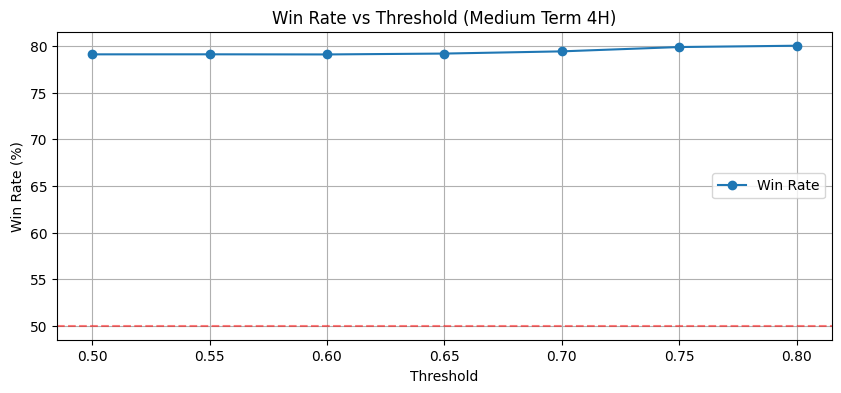


Saving Models...
All Models Saved.


In [5]:
# 5. Meta-Model Aggregation (XGBoost) & Final Evaluation
print("\nTraining Meta-Model (XGBoost Aggregation)...")

# Features for Meta-Model are the probabilities from each timeframe
meta_features = [c for c in df_base.columns if c.startswith('prob_')]
X_meta = df_base[meta_features]
y_meta = df_base['target_base']

# Split for Meta-Model Training
split_meta = int(len(df_base) * 0.5)
X_meta_train = X_meta.iloc[:split_meta]
y_meta_train = y_meta.iloc[:split_meta]
X_meta_test = X_meta.iloc[split_meta:]
y_meta_test = y_meta.iloc[split_meta:]

# Meta-Model: XGBoost
meta_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    scale_pos_weight=1.0,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
meta_model.fit(X_meta_train, y_meta_train)

# Evaluate Meta-Model
y_meta_pred = meta_model.predict(X_meta_test)
y_meta_prob = meta_model.predict_proba(X_meta_test)[:, 1]

print("\nMeta-Model Feature Importance:")
importances = meta_model.feature_importances_
for feat, imp in zip(meta_features, importances):
    print(f"  {feat}: {imp:.4f}")

# 6. Backtest Analysis across Thresholds
print("\nRunning Backtest Analysis across Thresholds (Medium Term: 4 Hours)...")

df_final_backtest = df_base.iloc[split_meta:].copy()
df_final_backtest['final_prob'] = y_meta_prob

# Calculate duration in days for Trades/Day metric
time_diff = df_final_backtest.index[-1] - df_final_backtest.index[0]
days_duration = time_diff.days + (time_diff.seconds / 86400)
print(f"Backtest Duration: {days_duration:.1f} days")

closes = df_final_backtest['close'].values
highs = df_final_backtest['high'].values
lows = df_final_backtest['low'].values
atrs = df_final_backtest['atr'].values
probs = df_final_backtest['final_prob'].values
times = df_final_backtest.index

# Simulation Parameters for 4 Hours on M5 data
SIM_FORWARD_BARS = 48 # 48 * 5min = 240min = 4 hours

thresholds = [0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80]
results = []

for threshold in thresholds:
    trades = []
    for i in range(len(df_final_backtest) - SIM_FORWARD_BARS):
        if probs[i] > threshold:
            entry_price = closes[i]
            atr = atrs[i]
            
            tp = entry_price + (atr * TP_ATR_MULT)
            sl = entry_price - (atr * SL_ATR_MULT)
            
            outcome = "HOLD"
            pnl = 0
            
            for j in range(1, SIM_FORWARD_BARS + 1):
                future_high = highs[i+j]
                future_low = lows[i+j]
                
                if future_low <= sl:
                    outcome = "LOSS"
                    pnl = sl - entry_price
                    break
                
                if future_high >= tp:
                    outcome = "WIN"
                    pnl = tp - entry_price
                    break
            
            if outcome == "HOLD":
                exit_price = closes[i+SIM_FORWARD_BARS]
                pnl = exit_price - entry_price
                outcome = "TIME_EXIT"
                
            trades.append({
                'Result': outcome,
                'PnL': pnl
            })
    
    if trades:
        trade_df = pd.DataFrame(trades)
        win_rate = len(trade_df[trade_df['Result'] == 'WIN']) / len(trade_df) * 100
        total_pnl = trade_df['PnL'].sum()
        avg_pnl = trade_df['PnL'].mean()
        trades_per_day = len(trades) / days_duration if days_duration > 0 else 0
        
        results.append({
            'Threshold': threshold,
            'Trades': len(trades),
            'Trades/Day': trades_per_day,
            'Win Rate': win_rate,
            'Total PnL': total_pnl,
            'Avg PnL': avg_pnl
        })
    else:
        results.append({
            'Threshold': threshold,
            'Trades': 0,
            'Trades/Day': 0.0,
            'Win Rate': 0.0,
            'Total PnL': 0.0,
            'Avg PnL': 0.0
        })

results_df = pd.DataFrame(results)
print("\nPerformance by Threshold:")
print(results_df.to_string(index=False, float_format=lambda x: "{:.4f}".format(x)))

# Plot Win Rate vs Threshold
plt.figure(figsize=(10, 4))
plt.plot(results_df['Threshold'], results_df['Win Rate'], marker='o', label='Win Rate')
plt.axhline(y=50, color='r', linestyle='--', alpha=0.5)
plt.title('Win Rate vs Threshold (Medium Term 4H)')
plt.xlabel('Threshold')
plt.ylabel('Win Rate (%)')
plt.grid(True)
plt.legend()
plt.show()

# Save Models
print("\nSaving Models...")
for tf, model in ensemble_models.items():
    joblib.dump(model, MODEL_DIR / f"ensemble_{tf}.joblib")
    joblib.dump(scalers[tf], MODEL_DIR / f"scaler_{tf}.joblib")

joblib.dump(meta_model, MODEL_DIR / "meta_model_xgb.joblib")
print("All Models Saved.")